In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import folium 
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import json
from tqdm import tqdm
import time

get latest ghd data

In [87]:
# %cd ghd_data
resp = requests.get('https://groundhog-day.com/api/v1/groundhogs')
df_hogs = pd.DataFrame(resp.json()['groundhogs'])#.drop(['predictions'], axis = 1)
df_hogs['longitude'] = pd.to_numeric(df_hogs['coordinates'].str.split(',').str[1])
df_hogs['latitude'] = pd.to_numeric(df_hogs['coordinates'].str.split(',').str[0])
df_hogs.to_csv('hogs.csv', index = False)

extract groundhog locations and plot on map

In [89]:
map = folium.Map(location=[df_hogs['latitude'].mean(),
                            df_hogs['longitude'].mean()], 
                zoom_start =4, 
                zoom_control=False)

for _, row in df_hogs.iterrows():
    if row['isGroundhog']:
        folium.Marker(location=[row['latitude'], row["longitude"]], popup=row['slug'], icon = folium.Icon(color='green')).add_to(map)
    else:
        folium.Marker(location=[row['latitude'], row["longitude"]], popup=row['slug'], icon = folium.Icon(color='red')).add_to(map)

# map

explore prognosticators

<AxesSubplot: title={'center': 'Count by Prognosticator Type'}>

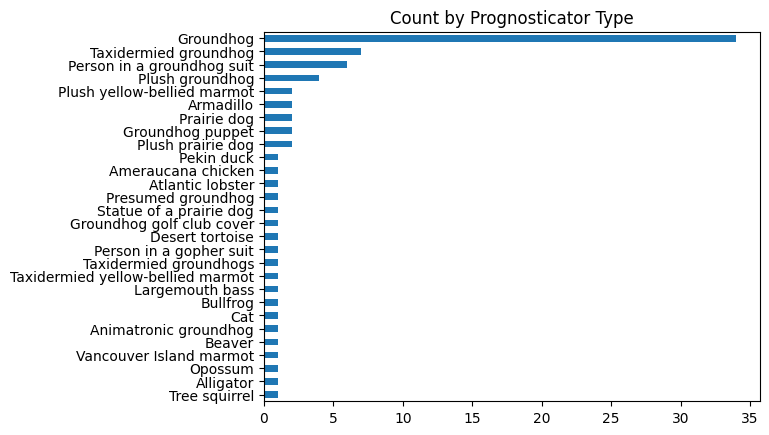

In [10]:
df_hogs['type'].value_counts(ascending=True).plot(kind='barh',
                                                  title = 'Count by Prognosticator Type')

explode out predictions from each prognosticator

In [22]:
progs = pd.DataFrame(resp.json()['groundhogs'])
dfs = []
for i, d in progs.iterrows():
    df = pd.DataFrame(d['predictions'])
    df = df.assign(**d[['id', 'slug']].to_dict())[['id', 'slug', 'year', 'shadow', 'details']]
    df.to_csv(f'{d["slug"]}.csv', index = False)
    dfs.append(df)

In [19]:
example_dict = d[['id', 'slug']].to_dict()

In [20]:
def my_functions(id, slug):
    print(f'the id is {id} - the slug is {slug}')

my_functions(5, 'rob')
my_functions(id=example_dict['id'], slug=example_dict['slug'])
# Short way
my_functions(**example_dict)

the id is 5 - the slug is rob
the id is 80 - the slug is elliott-the-groundhog
the id is 80 - the slug is elliott-the-groundhog


In [25]:
df_all = pd.concat(dfs).reset_index(drop=True).copy()

In [28]:
df_all['slug'].value_counts()

punxsutawney-phil        139
octoraro-orphie           99
wiarton-willie            70
jimmy-the-groundhog       56
concord-charlie           46
                        ... 
pisgah-penny               3
queen-city-charlie         3
unadilla-billie            3
cedar-the-groundhog        2
elliott-the-groundhog      1
Name: slug, Length: 80, dtype: int64

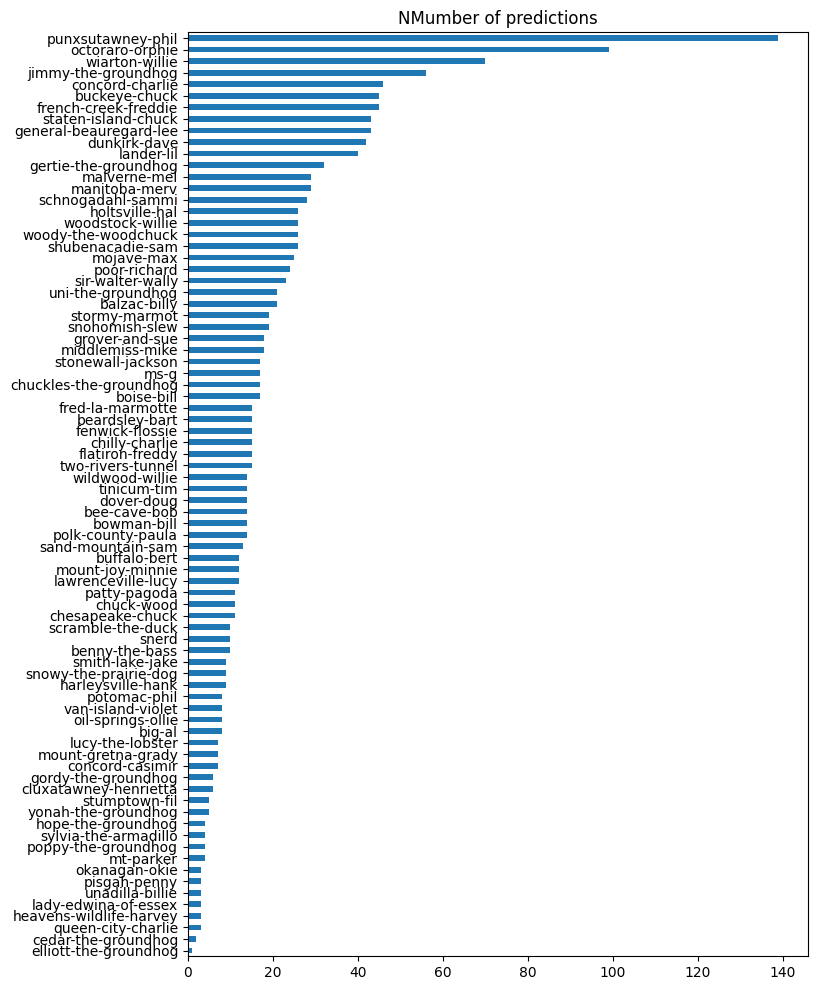

In [40]:
df_all['slug'].value_counts().sort_values(ascending=True) \
.plot(kind='barh',figsize=(8,12), title='Number of predictions')
plt.show()

In [49]:
good_progs = df_all['slug'].value_counts().to_frame().query('slug > 20').index.tolist()

<AxesSubplot: xlabel='year', ylabel='slug'>

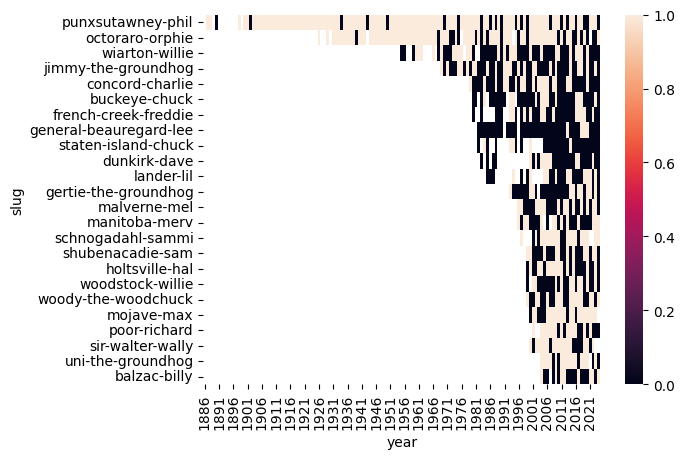

In [76]:
raw_preds = df_all[df_all['slug'].isin(good_progs)].groupby(['slug', 'year'])['shadow'].first().unstack().T
sns.heatmap(raw_preds[good_progs].T)

pull historic weather using longitude and latitude 

In [64]:
df_all

,id,slug,year,shadow,details
0,1,punxsutawney-phil,1886,NaN,Groundhog Day first recognized in Punxsutawney...
1,1,punxsutawney-phil,1887,1.0,First Official trek to Gobbler’s Knob. Saw Sha...
2,1,punxsutawney-phil,1888,1.0,Saw Shadow.
3,1,punxsutawney-phil,1889,NaN,No Record.
4,1,punxsutawney-phil,1890,0.0,No Shadow.
...,...,...,...,...,...
1566,78,unadilla-billie,2023,1.0,
1567,78,unadilla-billie,2024,0.0,
1568,79,cedar-the-groundhog,2023,0.0,
1569,79,cedar-the-groundhog,2024,0.0,


In [69]:
raw_preds['punxsutawney-phil'].astype(bool) # will make null values true 

year
1886     True
1887     True
1888     True
1889     True
1890    False
        ...  
2020    False
2021     True
2022     True
2023     True
2024    False
Name: punxsutawney-phil, Length: 139, dtype: bool

In [156]:
# sns.heatmap(raw_preds[good_progs].replace({0:'Early Spring', 1:'Long Winter'}).T)
                                                                        
def get_historical_weather(latitude, longitude, start_date, end_date): 
    daily_codes = ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max",
            "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration",
            "precipitation_sum", "rain_sum", "snowfall_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max",
            "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]
    daily_codes = ','.join(daily_codes)
    url = f"https://archive-api.open-meteo.com/v1/era5?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily={daily_codes}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        # print("Failed to retrieve data:", response.status_code)
        return None
    
# # Example usage
# latitude = 52.52
# longitude = 13.41
# start_date = "2021-01-01"
# end_date = "2021-12-31"
# weather_data = get_historical_weather(latitude, longitude, start_date, end_date)
# if weather_data:
#     print(json.dumps(weather_data, indent = 2))


{
  "latitude": 52.54833,
  "longitude": 13.407822,
  "generationtime_ms": 10.467052459716797,
  "utc_offset_seconds": 0,
  "timezone": "GMT",
  "timezone_abbreviation": "GMT",
  "elevation": 38.0,
  "daily_units": {
    "time": "iso8601",
    "weather_code": "wmo code",
    "temperature_2m_max": "\u00b0C",
    "temperature_2m_min": "\u00b0C",
    "temperature_2m_mean": "\u00b0C",
    "apparent_temperature_max": "\u00b0C",
    "apparent_temperature_min": "\u00b0C",
    "apparent_temperature_mean": "\u00b0C",
    "sunrise": "iso8601",
    "sunset": "iso8601",
    "daylight_duration": "s",
    "sunshine_duration": "s",
    "precipitation_sum": "mm",
    "rain_sum": "mm",
    "snowfall_sum": "cm",
    "precipitation_hours": "h",
    "wind_speed_10m_max": "km/h",
    "wind_gusts_10m_max": "km/h",
    "wind_direction_10m_dominant": "\u00b0",
    "shortwave_radiation_sum": "MJ/m\u00b2",
    "et0_fao_evapotranspiration": "mm"
  },
  "daily": {
    "time": [
      "2021-01-01",
      "2021-01-

In [167]:
df_all.dropna(subset=['shadow'])

,id,slug,year,shadow,details
1,1,punxsutawney-phil,1887,1.0,First Official trek to Gobbler’s Knob. Saw Sha...
2,1,punxsutawney-phil,1888,1.0,Saw Shadow.
4,1,punxsutawney-phil,1890,0.0,No Shadow.
12,1,punxsutawney-phil,1898,1.0,Saw Shadow.
14,1,punxsutawney-phil,1900,1.0,Saw Shadow.
...,...,...,...,...,...
1566,78,unadilla-billie,2023,1.0,
1567,78,unadilla-billie,2024,0.0,
1568,79,cedar-the-groundhog,2023,0.0,
1569,79,cedar-the-groundhog,2024,0.0,


In [161]:
all_weather = []
for i, d in tqdm(df_hogs.iterrows()):
    pred_years = pd.DataFrame(d['predictions']).dropna(subset=['shadow'])
    for year in pred_years['year'].values:
        time.sleep(1)
        # print(f'pulling for {d["slug"]} - year {year}')
        start_date = f"{year}-01-01"
        end_date = f"{year}-04-01"  
        weather_data = get_historical_weather(d['latitude'], 
                                              d['longitude'], 
                                              start_date,
                                              end_date)
        if not weather_data:
            # print('no weather')
            pass
        else:
            df_weather = pd.DataFrame(weather_data['daily']).assign(slug=d['slug'], year=year)
            all_weather.append(df_weather)
    break
df_all_weather = pd.concat(all_weather)
df_all_weather.to_csv('historical_weather.csv')

pulling for punxsutawney-phil - year 1887
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1888
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1890
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1898
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1900
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1901
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1902
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1903
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1904
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1905
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1906
Failed to retrieve data: 400
no weather
pulling for punxsutawney-phil - year 1907
Failed to retrieve data: 400
no weather
pulling for punx

In [178]:
df_all_weather['shadow'] = df_all_weather['year'].map(df_all.query('slug=="punxsutawney-phil"').set_index('year')['shadow'])
df_all_weather['month'] = pd.to_datetime(df_all_weather['time']).dt.month
sns.boxplot(df_all_weather.query('month>=2'), x='shadow', y='temperature_2m_mean')

In [190]:
df_yearly_avg_temp = df_all_weather.query('month>=2').groupby(['year', 'shadow'])['temperature_2m_mean'].mean().reset_index()
sns.boxplot(df_yearly_avg_temp, x='shadow', y='temperature_2m_mean')